# Task-1: Titanic survivors prediction

## Importing libraries

In [235]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Importing Data

In [236]:
df=pd.read_csv("Titanic-Dataset.csv")

In [237]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [238]:
names=df["Name"]

## Data Preprocessing

### Missing values check

In [239]:
df.isna().sum()[df.isna().sum()>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

<b>Handling missing values in Age by imputing with mean:

In [240]:
df["Age"]=df["Age"].fillna(df["Age"].mean())

<b> Handling missing values in Embarked using mode:

In [241]:
df['Embarked']=df['Embarked'].fillna(df["Embarked"].mode()[0])

<b>Handling missing values in Cabin by feature engineering:

In [242]:
#Creating new feature detecting presence of Cabin number
df["In_Cabin"]=df['Cabin'].notnull().astype(int)

In [243]:
# Checking if low fares and Cabin presence are reated
fare_compare = df.groupby('In_Cabin')['Fare'].describe()
fare_compare

,count,mean,std,min,25%,50%,75%,max
In_Cabin,,,,,,,,
0,687.0,19.157325,28.663343,0.0,7.877100,10.50000,23.00000,512.3292
1,204.0,76.141504,74.391749,0.0,29.453125,55.22085,89.32815,512.3292


We see that people with value 0 had paid mean price around 19 whereas those 1 had 76 i.e. a significant difference. We can say from this information that the poor passengers have cabin info listed as NaN(0)

Thus we may say that NaN values correspond to "No cabin assgined" rather than missing data.


In [244]:
#Confirm with cross tab
pd.crosstab(df['Pclass'], df['In_Cabin'], normalize='index') * 100


In_Cabin,0,1
Pclass,,
1,18.518519,81.481481
2,91.304348,8.695652
3,97.556008,2.443992


We see that it is the 2nd and 3rd class passengers who mostly have Nan(0) values in cabin info. So Nan values definitely correspond to poor passengers with "No cabin assigned" in the data.

The logic here is that, 0 values in "In_Cabin" signify that those passengers donot have a cabin rather than it being missing data.

In [245]:
df=df.drop("Cabin",axis=1)

<b> Final check of missing values:

In [246]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
In_Cabin       0
dtype: int64

### Dropping irrelevant features

<b> Dropping "PassengerId", "Name" and "Ticket" as they are random and should not have any effect on survival

In [247]:
df=df.drop(["PassengerId","Name","Ticket"],axis=1)

### Encoding categorical features

<b>Encoding "Sex"

In [248]:
df["Sex"]=df["Sex"].apply(lambda x: 0 if x=="male" else 1)

<b> Encoding "Embarked" port info 

In [249]:
df["Embarked"]=df["Embarked"].apply(lambda x: 0 if x=="S" else 1)

Possible preprocessings done. We move to EDA

## EDA

In [250]:
#numerical columns
num_df=df[["Age","Fare"]]
#Categorical columns
cat_df=df.drop(columns=num_df.columns)

### Overview of data

In [251]:
df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,In_Cabin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.274972,0.228956
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.446751,0.420397
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,0.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000


### Distribution Shape of features 

<b>Numerical features

Text(0.5, 1.0, 'Fare Distribution')

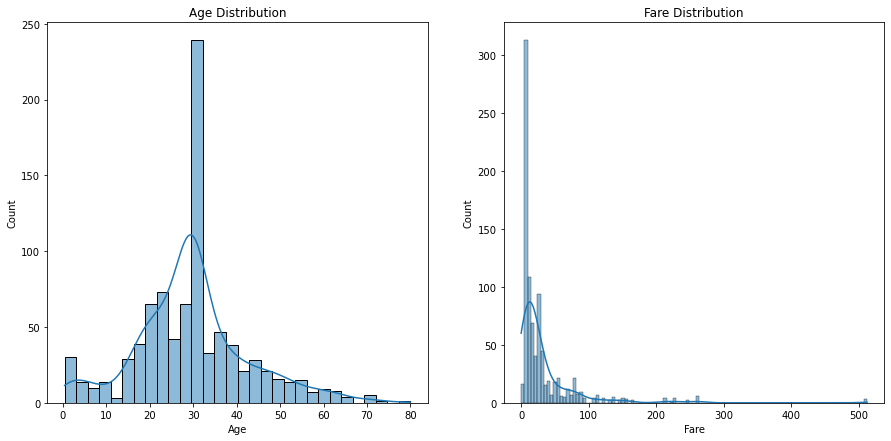

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plotting for 'Age'
sns.histplot(num_df['Age'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

# Plotting for 'Fare'
sns.histplot(num_df['Fare'], kde=True, ax=axes[1])
axes[1].set_title('Fare Distribution')

We see that Fares are higly positively skewed.

<b> Categorical features

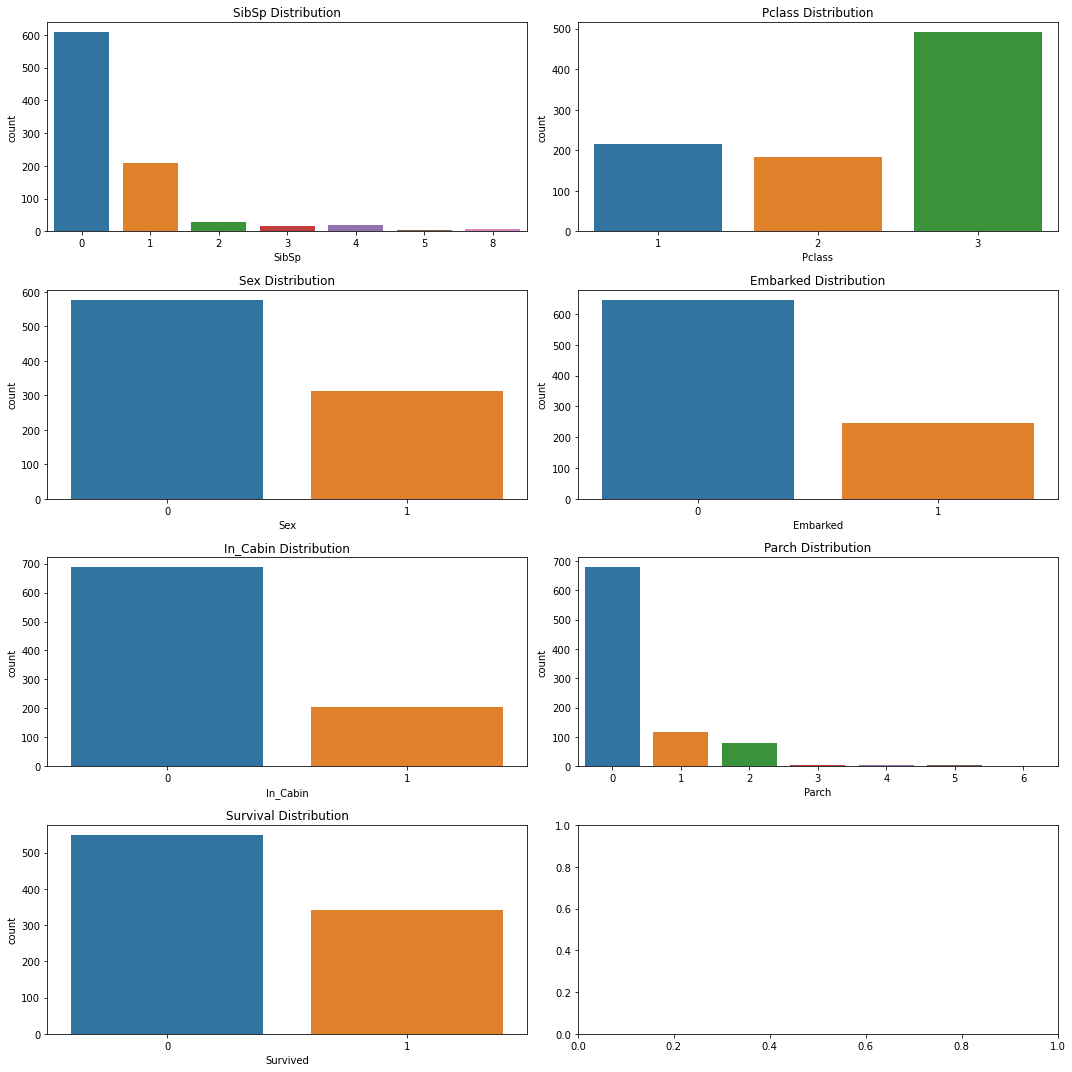

In [253]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))  # 3 rows, 2 columns


# Plotting for SibSp
sns.countplot(x='SibSp', data=df, ax=axes[0, 0])
axes[0, 0].set_title('SibSp Distribution')

# Plotting for Passenger class
sns.countplot(x='Pclass', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Pclass Distribution')

# Plotting for Sex
sns.countplot(x='Sex', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Sex Distribution')

# Plotting for Embarked
sns.countplot(x='Embarked', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Embarked Distribution')

# Plotting for Cabin presence
sns.countplot(x='In_Cabin', data=df, ax=axes[2, 0])
axes[2, 0].set_title('In_Cabin Distribution')

# Plotting for Parch
sns.countplot(x='Parch', data=df, ax=axes[2, 1])
axes[2, 1].set_title('Parch Distribution')

# Plotting for Survival
sns.countplot(x='Survived', data=df, ax=axes[3, 0])
axes[3, 0].set_title('Survival Distribution')


plt.tight_layout()
plt.show()

We colcude that:

1. Most passengers were female

2. Most passengers  were 3rd class and didnot get cabin (i.e. most were not affluent financially)

3. Most embarked from S(here probably port Southhampton)

4. Low SibSp and Parch values indicate most passengers were either travellign alone or with a very small family unit.

5. Max people didnot survive.

### Pairplots

<b>Numerical features

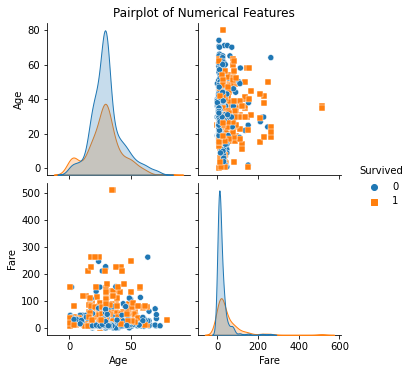

In [254]:
sns.pairplot(df[["Age","Fare","Survived"]], hue='Survived', markers=["o", "s"])
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


Shows that:

1. younger people survived more
2. People who paid higher fares i.e. had more priority, survived more

<b>Categorical features

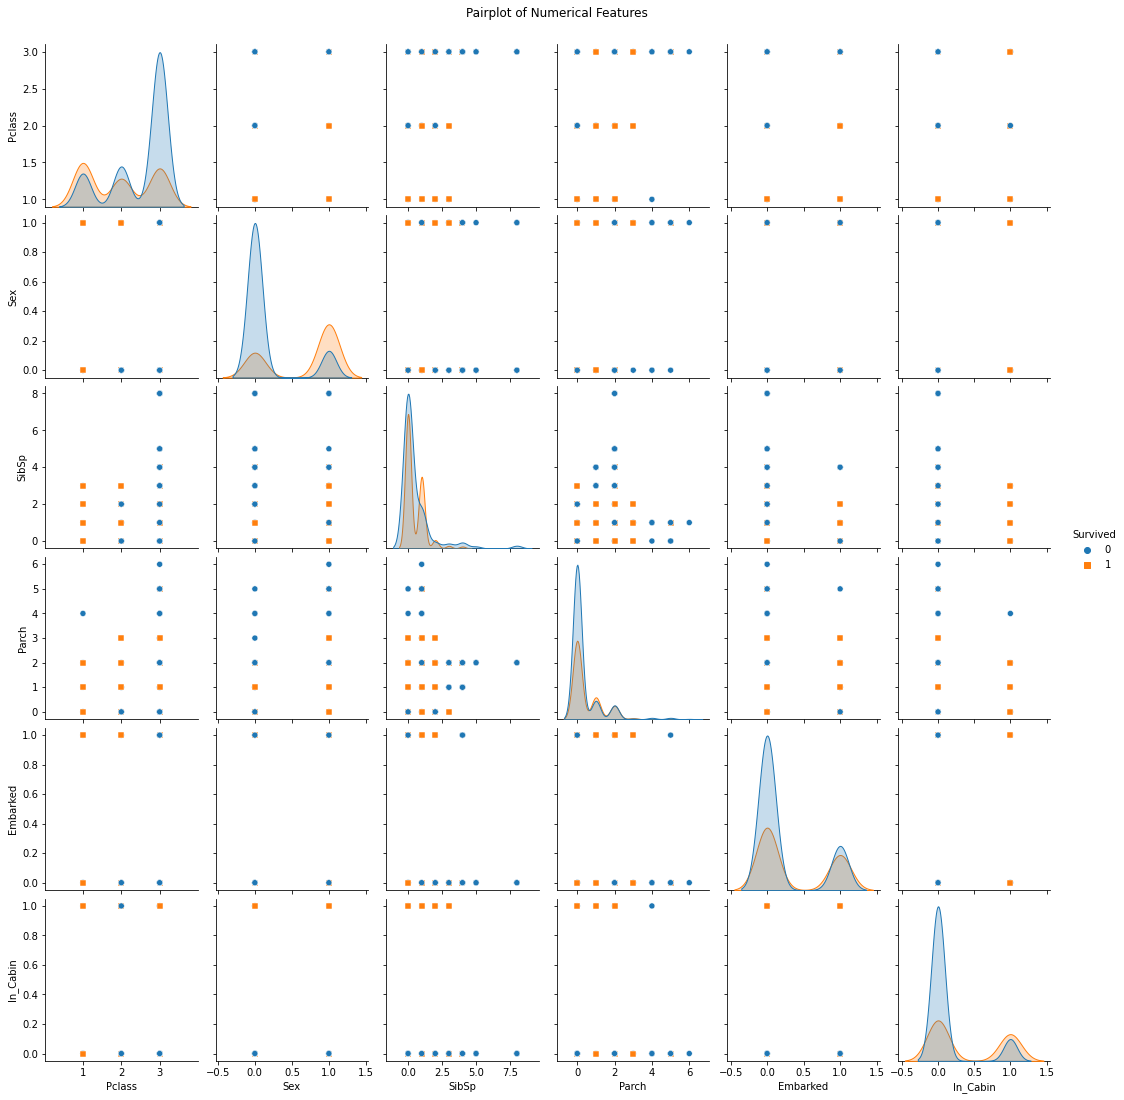

In [255]:
sns.pairplot(cat_df, hue='Survived', markers=["o", "s"])
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()


We see that:

1. Most people not in cabin didnot survive.
2. Most people embarking from S, didnot survive
3. Most males didnot survive.
4. Survival rates for lonely people were high and low alike

### Correlation Heatmap

In [256]:
num_df.columns

Index(['Age', 'Fare'], dtype='object')

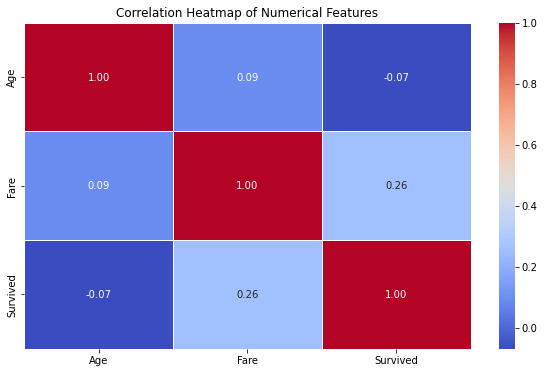

In [257]:
corr_df=df[["Age","Fare","Survived"]]
corr_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

Age and Fare are not really related in any significant way to each other or to survival.

### Outlier Detection

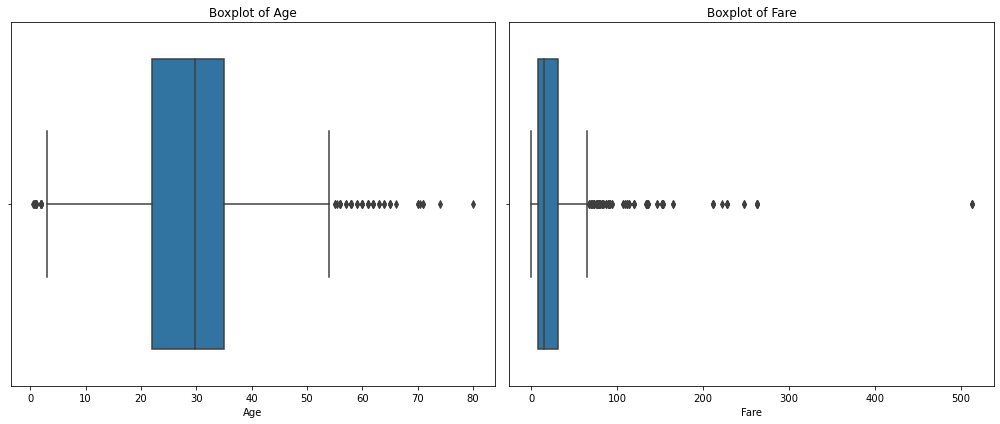

In [258]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for 'Age'
sns.boxplot(data=num_df, x='Age', ax=axes[0])
axes[0].set_title("Boxplot of Age")

# Boxplot for 'Fare'
sns.boxplot(data=num_df, x='Fare', ax=axes[1])
axes[1].set_title("Boxplot of Fare")

plt.tight_layout()
plt.show()


A lot of Outliers exist for Age and Fares. But there may be reasaonable reasons for these:

1. Age are not unreasonable. There could have bee be some old inidviduals on the ship
2. Fares are reasonable. Only one is high whichmay have been due to other social reasons.

So, we donot impute these values

### Standardizing data

In [269]:
scaler = StandardScaler()

df[num_df.columns.tolist()] = scaler.fit_transform(df[num_df.columns.tolist()])

## Train Test Split

In [270]:
X=df.drop("Survived",axis=1)
y=df["Survived"]

In [271]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Training

In [272]:
lr=LogisticRegression()

In [273]:
lr.fit(X_train,y_train)

LogisticRegression()

In [274]:
y_pred = lr.predict(X_test)

In [275]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)
print()

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[97 13]
 [21 48]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179


Accuracy: 0.8101


## Deploying model

<b>Deploying on full data and predicting:

In [276]:
lr.fit(X,y)

LogisticRegression()

In [277]:
predictions=lr.predict(X)

In [278]:
prediction_df=pd.DataFrame({"Name":names,"Actual Survival":df["Survived"],"Predicted Survival":predictions})
prediction_df

,Name,Actual Survival,Predicted Survival
0,"Braund, Mr. Owen Harris",0,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1
2,"Heikkinen, Miss. Laina",1,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1
4,"Allen, Mr. William Henry",0,0
...,...,...,...
886,"Montvila, Rev. Juozas",0,0
887,"Graham, Miss. Margaret Edith",1,1
888,"Johnston, Miss. Catherine Helen ""Carrie""",0,0
889,"Behr, Mr. Karl Howell",1,1
